# Train and evaluate on MNIST

In [2]:
import sys
sys.path.append('models')

In [3]:
import models.ExampleModels as em
import torch
import matplotlib.pyplot as plt 
import numpy as np

# Get Data

In [4]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torchsummary import summary

In [5]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [6]:
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

#train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
#valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Train Model

In [7]:
max_embed_size=40
min_p = .1
ae = em.AutoEncoder(max_embed_size,use_sq_dr= True,dr_min_p= min_p, scale_output=False)


Selected device: cpu


In [8]:
def plot_ae_outputs(ae,n=10):
    plt.figure(figsize=(16,4.5))
    encoder = ae.encoder
    decoder = ae.decoder
    device = ae.device
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   


 EPOCH 1/10 	 train loss 0.03534184396266937 	 val loss 0.019045112654566765


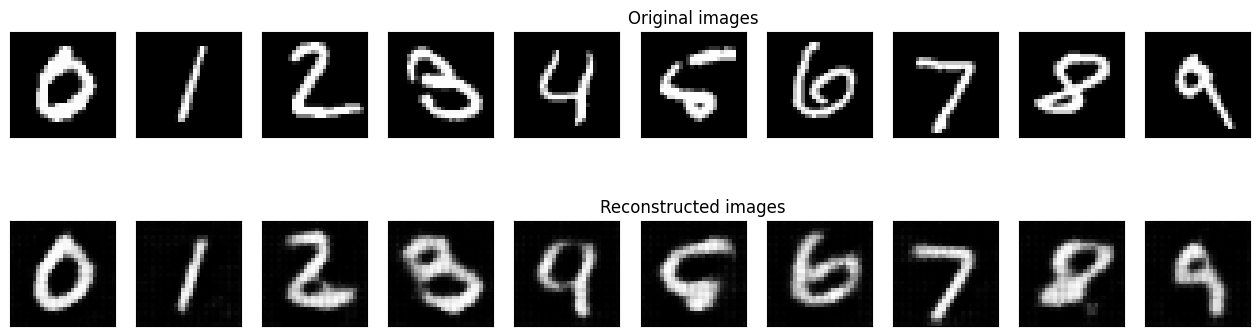


 EPOCH 2/10 	 train loss 0.017896847799420357 	 val loss 0.016974318772554398


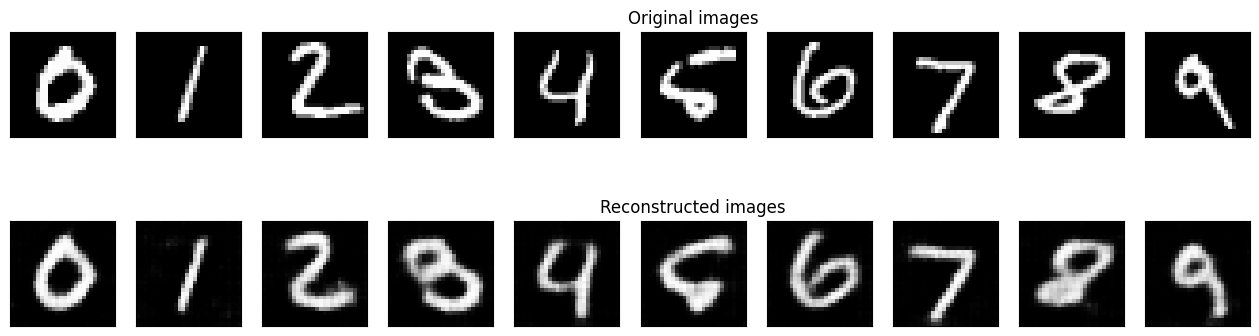


 EPOCH 3/10 	 train loss 0.0161129217594862 	 val loss 0.016361292451620102


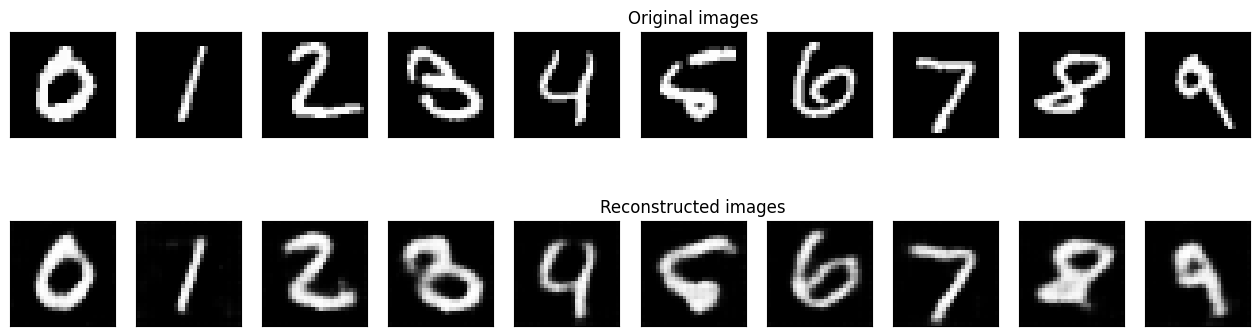


 EPOCH 4/10 	 train loss 0.015220033936202526 	 val loss 0.01573813520371914


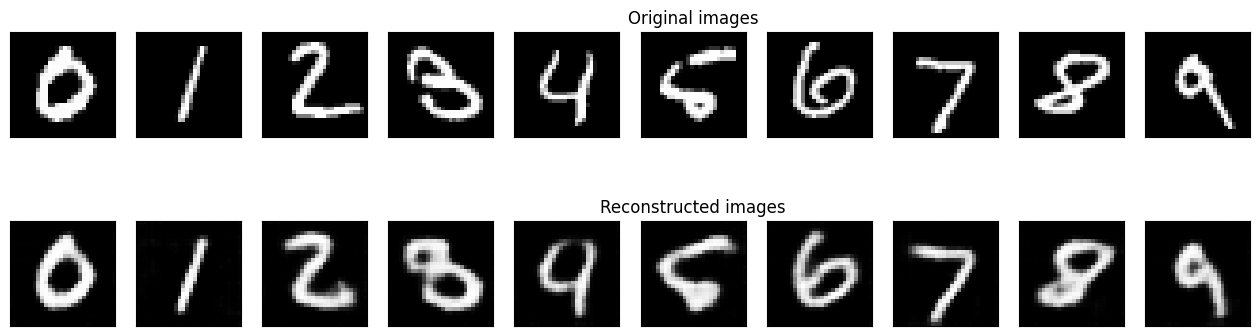


 EPOCH 5/10 	 train loss 0.014591241255402565 	 val loss 0.013927597552537918


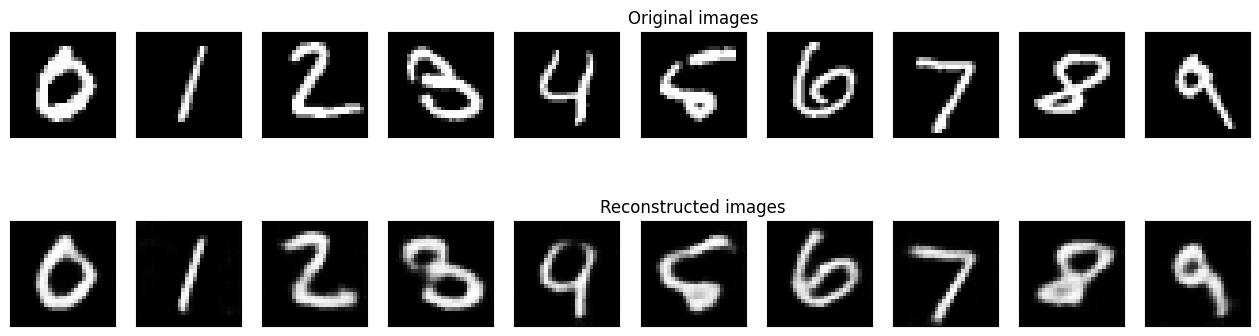


 EPOCH 6/10 	 train loss 0.014113146811723709 	 val loss 0.013048344291746616


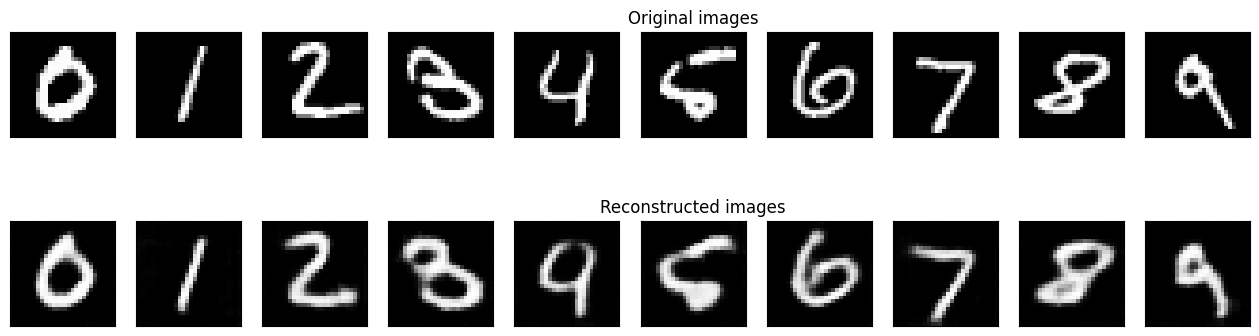


 EPOCH 7/10 	 train loss 0.014030071906745434 	 val loss 0.013652642257511616


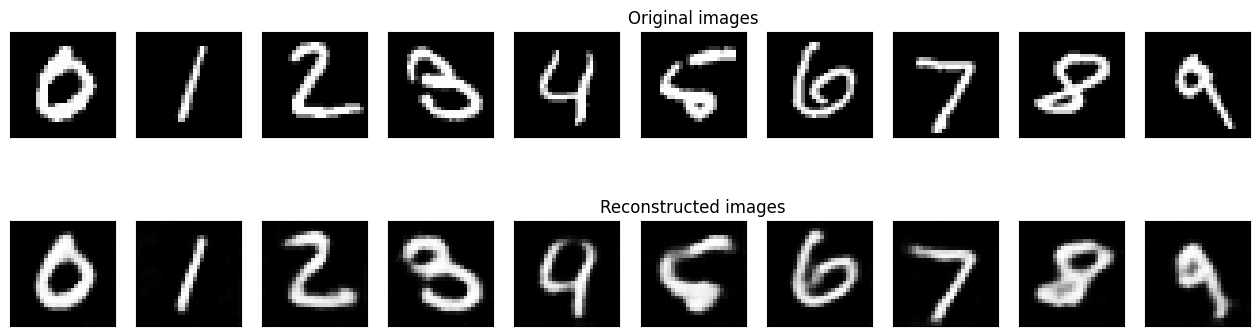


 EPOCH 8/10 	 train loss 0.013779734261333942 	 val loss 0.014606140553951263


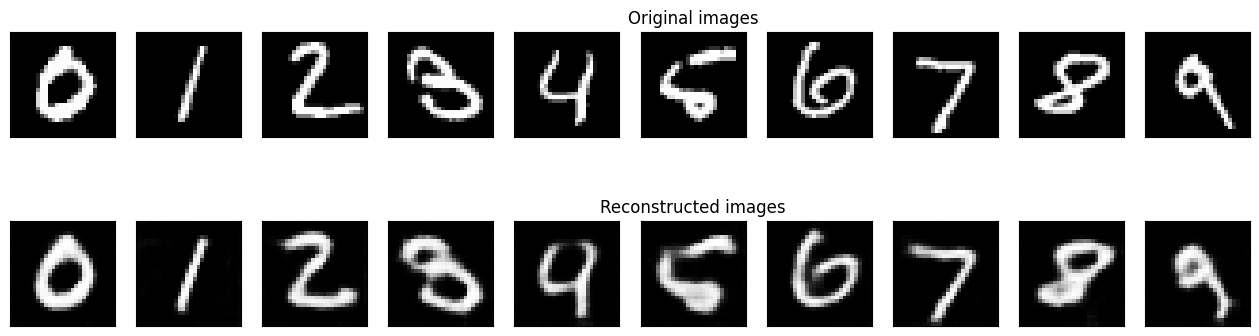


 EPOCH 9/10 	 train loss 0.01341036893427372 	 val loss 0.013485254719853401


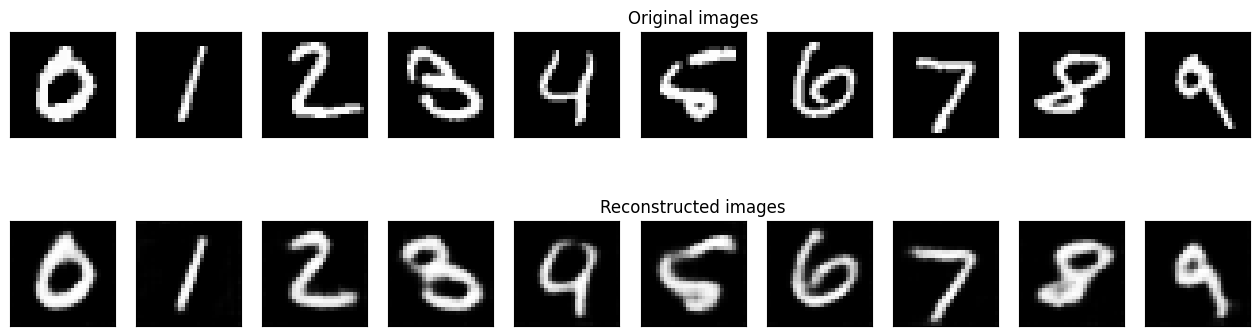


 EPOCH 10/10 	 train loss 0.013263491913676262 	 val loss 0.013162371702492237


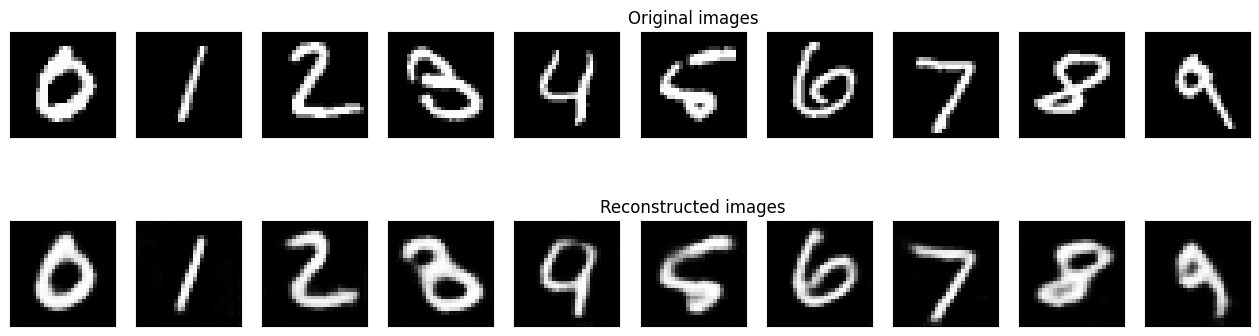

In [9]:
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(ae,n=10)

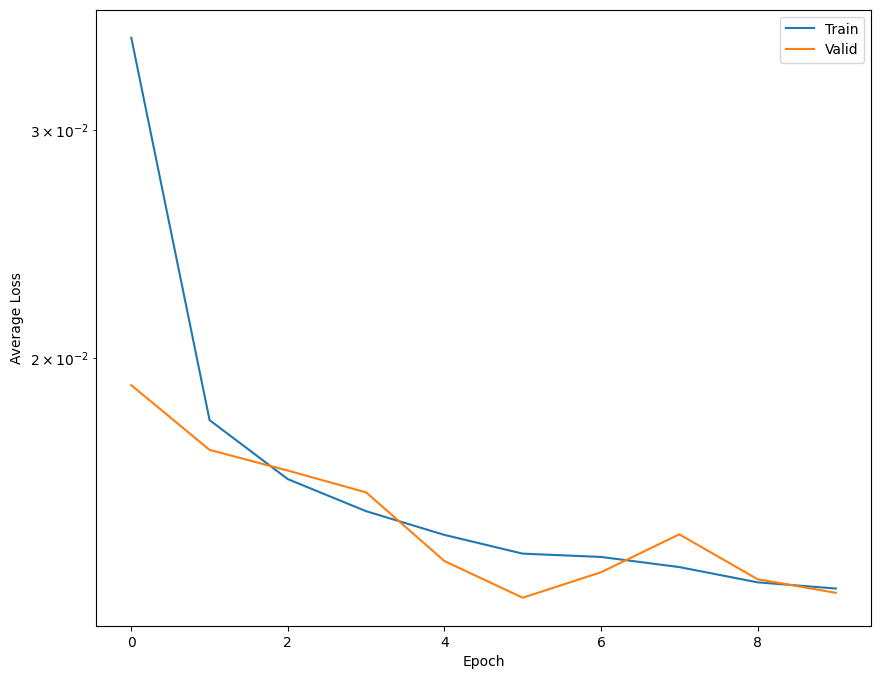

In [10]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# view ablation on an example

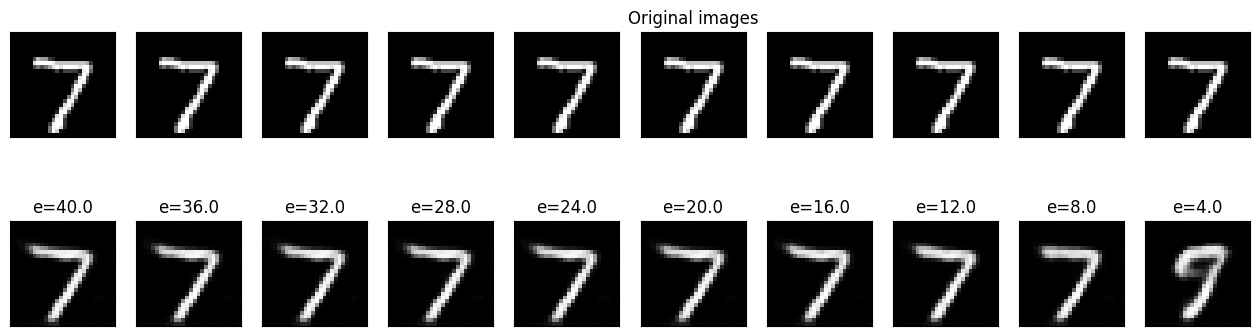

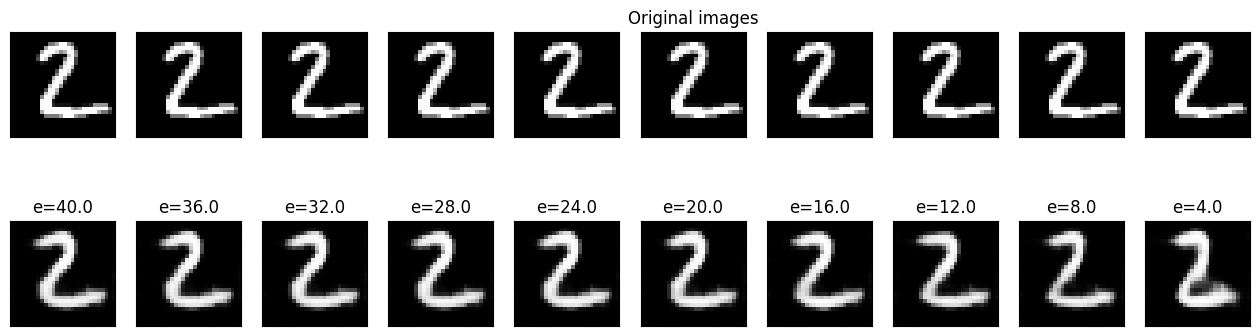

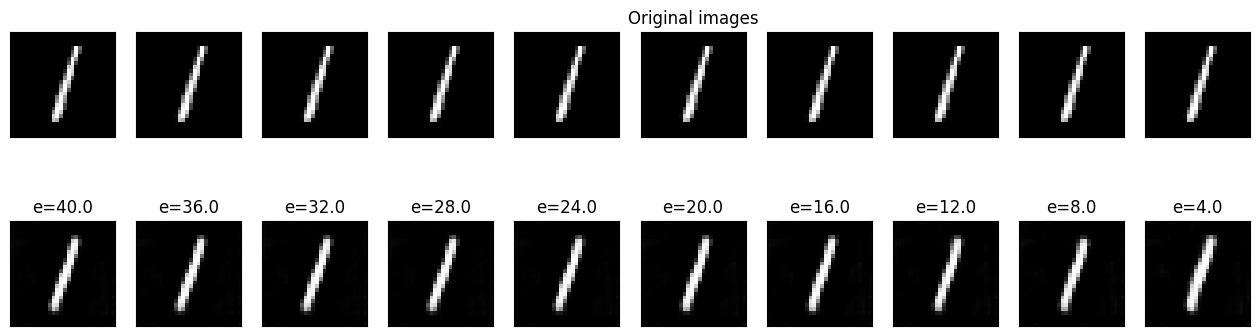

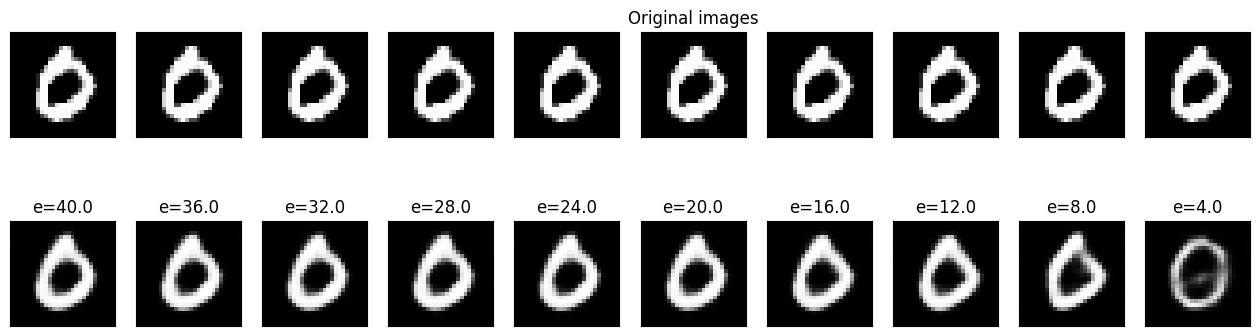

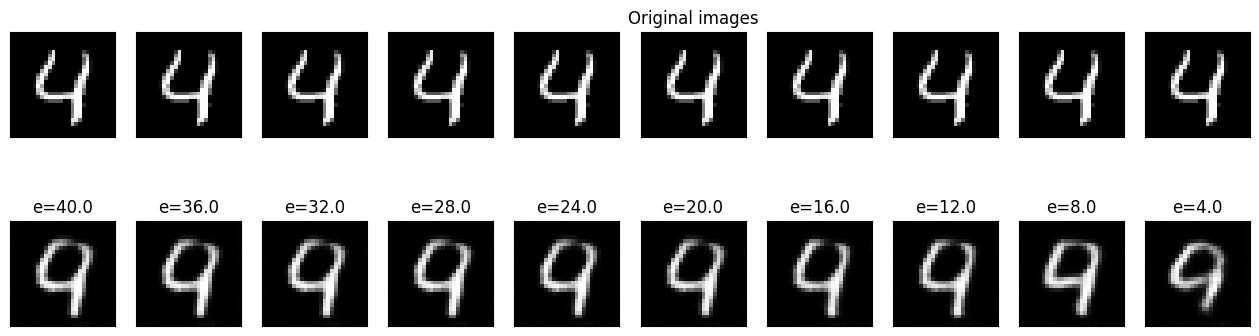

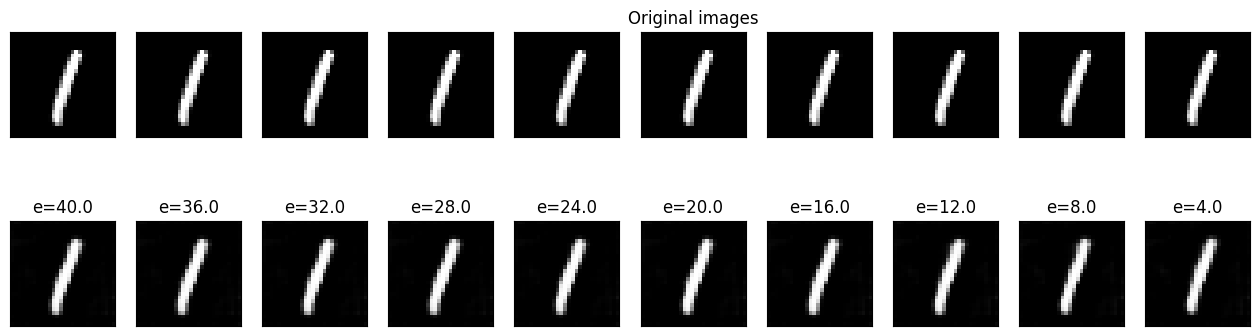

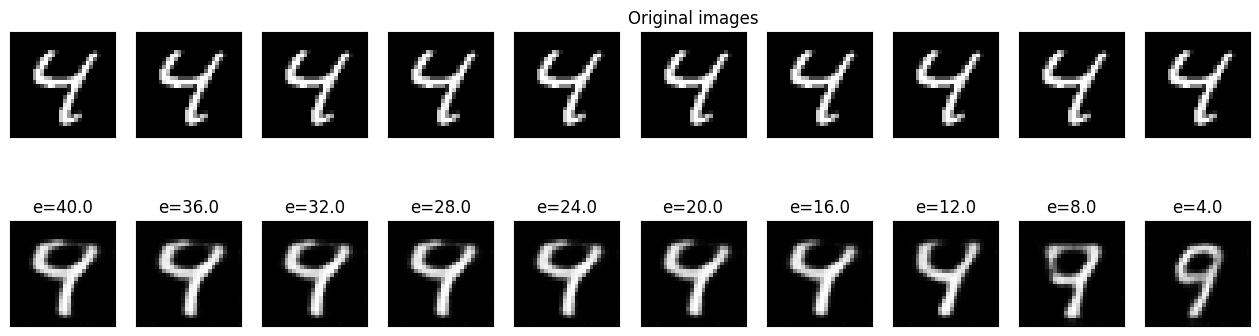

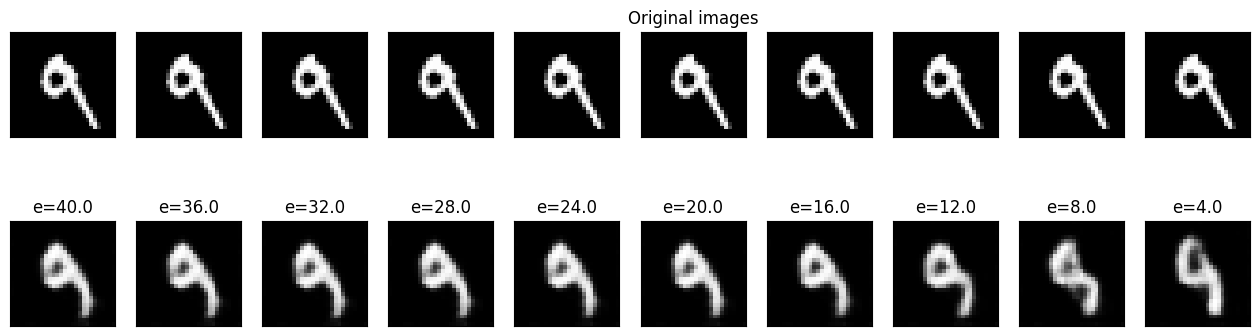

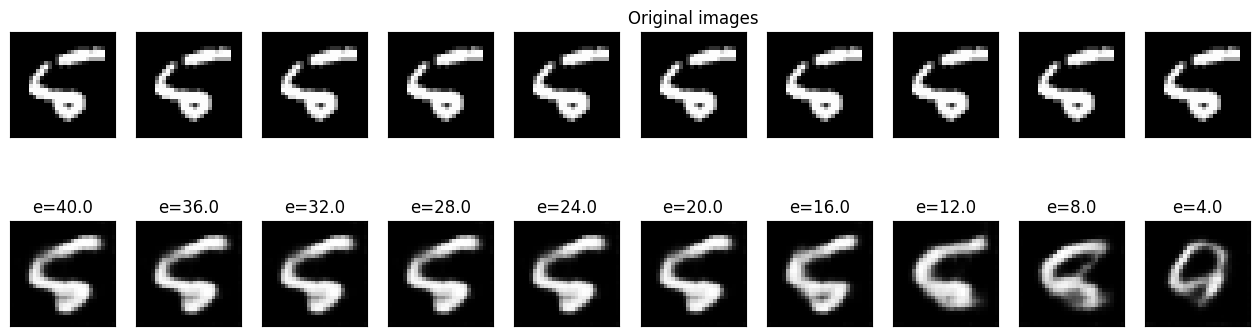

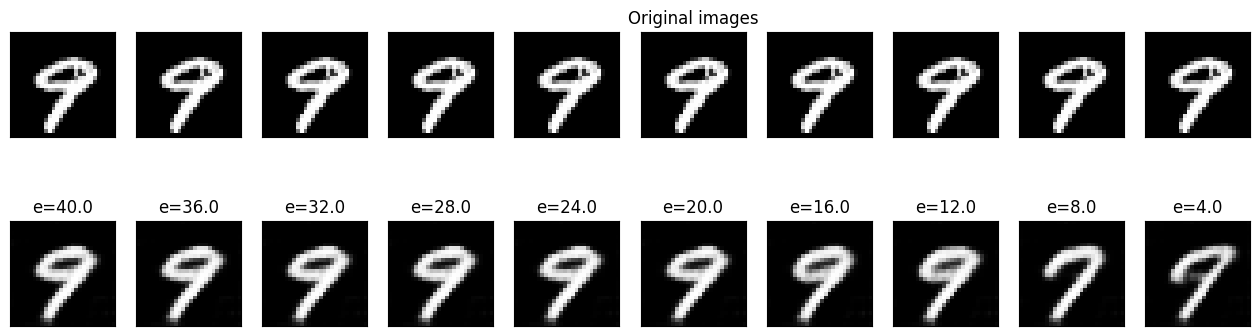

In [22]:
sample_idxs = range(10)
#sample_idx = 1
n = 10
r = np.rint(np.linspace(max_embed_size,int(max_embed_size* min_p),n))

encoder = ae.encoder
decoder = ae.decoder
device = ae.device
encoder.eval()
decoder.eval()
for sample_idx in sample_idxs:
    plt.figure(figsize=(16,4.5))
    img = test_dataset[sample_idx][0].unsqueeze(0).to(device)
    for i, embed_size in enumerate(r):
        
        ax = plt.subplot(2,n,i+1)
        with torch.no_grad():
            # ablate embedding
            embedding = encoder(img)
            #create mask

            if embed_size < embedding.shape[1]:

                embedding[0][-int(embedding.shape[1] - embed_size) :] = 0 

            rec_img  = decoder(embedding)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        #if i == n//2:
        #    ax.set_title('Reconstructed images')
        ax.set_title(f"e={embed_size}")
    plt.show()

# Reconstruction metrics - also compare to reduced precision

In [18]:
! pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/a3/7e/4cd853a855ac34b4ef3ef6a5c3d1c2e96eaca1154fc6be75db55ffa87393/scikit_image-0.22.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.8 from https://files.pythonhosted.org/packages/88/8c/9d1f74196c296046af1f20e6d3fc7fbb27387282315e1643f450bba14329/scipy-1.11.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 941.9 kB/s eta 0:00:00 0:00:01
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/9b/82/473e452d3f21a9cd7e792a827f8df58bdff614fd2fff33d7bf6c4c128da7/imageio-2.31.6-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/f5/72/68ea763b5f3e3d987149268305

In [19]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity # TODO maybe switch this to torchmetrics to run as batch

In [ ]:
def eval_metric(self, encoder, decoder, dataloader, metric, embed_size):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(self.device)
            # Encode data
            encoded_data = self.encoder(image_batch)
            # Decode data
            decoded_data = self.decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = self.loss_fn(conc_out, conc_label)
    return val_loss.data

In [26]:
#TODO finish me

n = 10
r = np.rint(np.linspace(max_embed_size,int(max_embed_size* min_p),n))

encoder = ae.encoder
decoder = ae.decoder
device = ae.device

# enumerate embedding sizes
avg_psnrs=[]
for i, embed_size in enumerate(r):
    #enumerate test dataset
    print(i)
    psnrs = []
    for sample_idx in range(len(test_dataset)):
        img = test_dataset[sample_idx][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            # ablate embedding
            embedding = encoder(img)
            #create mask

            if embed_size < embedding.shape[1]:

                embedding[0][-int(embedding.shape[1] - embed_size) :] = 0 

            rec_img  = decoder(embedding)
        ic= img.cpu().squeeze().numpy()
        
        rc=rec_img.cpu().squeeze().numpy()
        psnrs.append(peak_signal_noise_ratio(ic, rc))
    avg_psnrs.append(sum(psnrs)/len(psnrs))

0
1
2
3
4
5
6
7
8
9


In [27]:
print(avg_psnrs)

[19.3683874920177, 19.44038766547666, 19.44956071638355, 19.453686735148267, 19.451278344753398, 19.376611860875368, 19.074736822402485, 18.385730650524142, 17.10538751621945, 14.172421943178305]
